In [ ]:

import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def weighted_mean_absolute_percentage_error(y_true, y_pred): 
    return np.sum(np.abs((y_true - y_pred) / y_true) * 100 * y_true)/np.sum(y_true)

# Data Overview


In [ ]:
df = pd.read_excel('drive/MyDrive/Sell_in_Twitter_Sentiment_google/Sell_In_with_Twitter_Sentiment_Google_Trends.xlsx', sheet_name = 'Data')

In [ ]:
df.head()

,Week,Total_Sell_in,Total_Sell_in1,Total_Sell_in2,Total_Sell_in3,Total_Sell_in4,Total_Sell_in5,Sentiment Lag 0,Sentiment Lag 1,Sentiment Lag 2,Sentiment Lag 3,Sentiment Lag 4,Sentiment Lag 5,Google Trends Lag 0,Google Trends Lag 1,Google Trends Lag 2,Google Trends Lag 3,Google Trends Lag 4,Google Trends Lag 5
0,2017-01-08,20319.0,NaN,NaN,NaN,NaN,NaN,0.994660,0.998213,0.999767,0.998217,0.612424,0.928982,63,48,96,45,56,69
1,2017-01-15,77327.0,20319.0,NaN,NaN,NaN,NaN,0.180219,0.994660,0.998213,0.999767,0.998217,0.612424,44,63,48,96,45,56
2,2017-01-22,41367.0,77327.0,20319.0,NaN,NaN,NaN,0.996948,0.180219,0.994660,0.998213,0.999767,0.998217,50,44,63,48,96,45
3,2017-01-29,96033.0,41367.0,77327.0,20319.0,NaN,NaN,0.606942,0.996948,0.180219,0.994660,0.998213,0.999767,35,50,44,63,48,96
4,2017-02-05,21446.0,96033.0,41367.0,77327.0,20319.0,NaN,0.711777,0.606942,0.996948,0.180219,0.994660,0.998213,56,35,50,44,63,48


In [ ]:
df = df[['Week', 'Total_Sell_in']]

In [ ]:
df.describe()

,Total_Sell_in
count,156.000000
mean,51365.195769
std,35209.456703
min,729.000000
25%,27164.250000
50%,45364.500000
75%,69490.000000
max,218711.000000


In [ ]:

df.Week

0     2017-01-08
1     2017-01-15
2     2017-01-22
3     2017-01-29
4     2017-02-05
         ...    
151   2019-12-01
152   2019-12-08
153   2019-12-15
154   2019-12-22
155   2019-12-29
Name: Week, Length: 156, dtype: datetime64[ns]

In [ ]:
df.Week = pd.to_datetime(df['Week'], format='%Y/%m/%d')

In [ ]:
train_df=df[:130]
test_df = df[130:]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


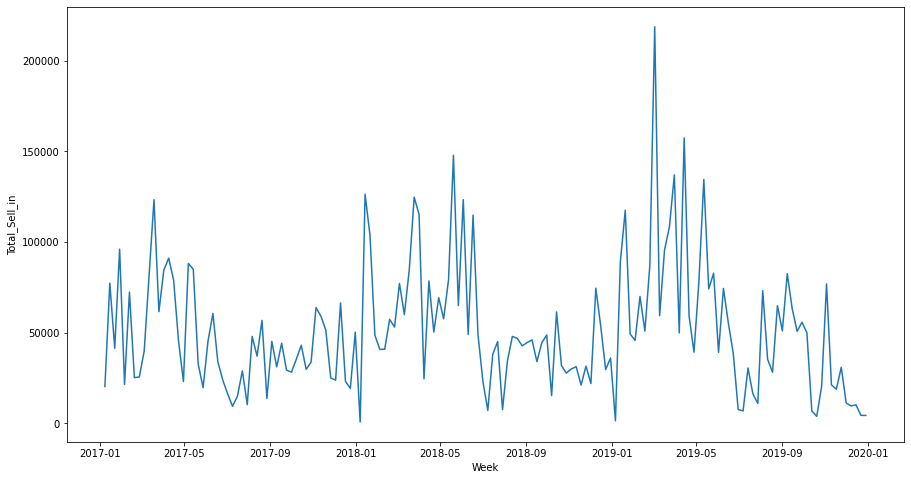

In [ ]:
plt.figure(figsize = (15,8))
sns.lineplot(df.Week, df.Total_Sell_in);

In [ ]:
df['month'] = pd.DatetimeIndex(df['Week']).month 

In [ ]:
df['year'] = pd.DatetimeIndex(df['Week']).year

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


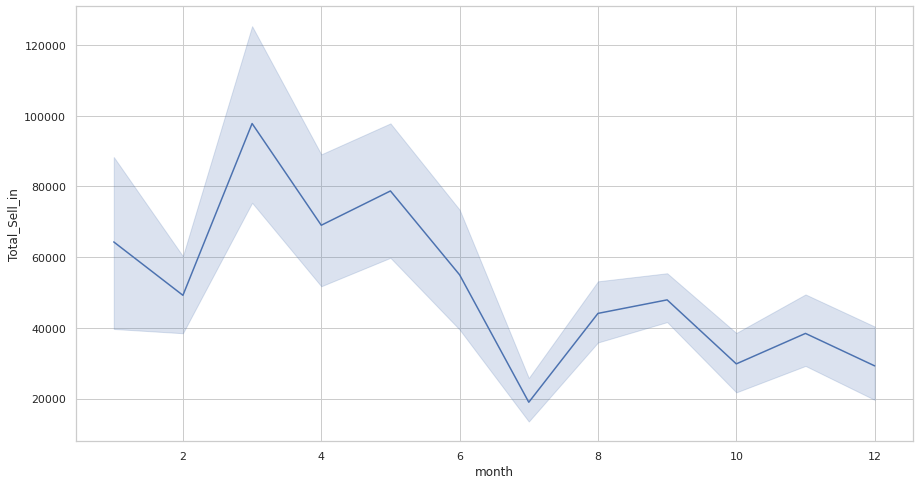

In [ ]:
plt.figure(figsize = (15,8))
sns.lineplot(df.month, df.Total_Sell_in);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


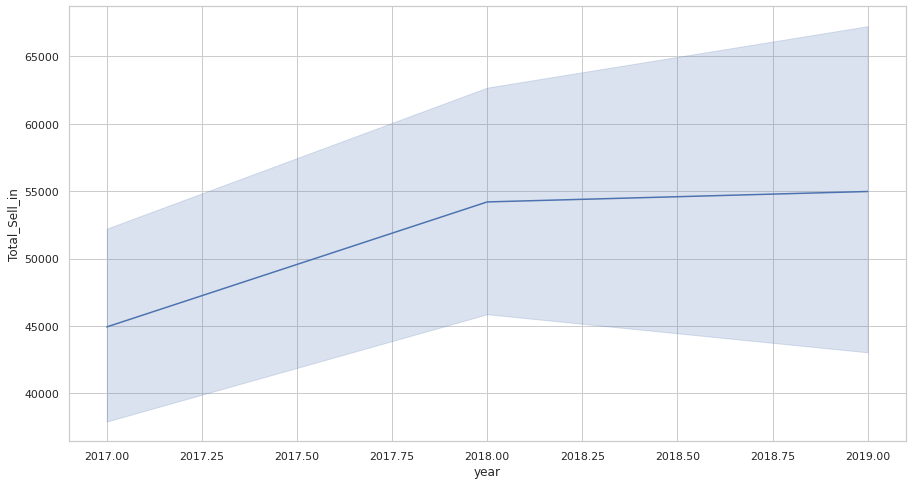

In [ ]:
fig = plt.figure(figsize=(15,8))
sns.set(style='whitegrid')

sns.lineplot(df.year, df.Total_Sell_in);

The increment is quite steep during 2017-2018 after that it becomes constant

In [ ]:
data = pd.pivot_table(df, index=df.month, columns=df.year,values='Total_Sell_in', aggfunc='sum')

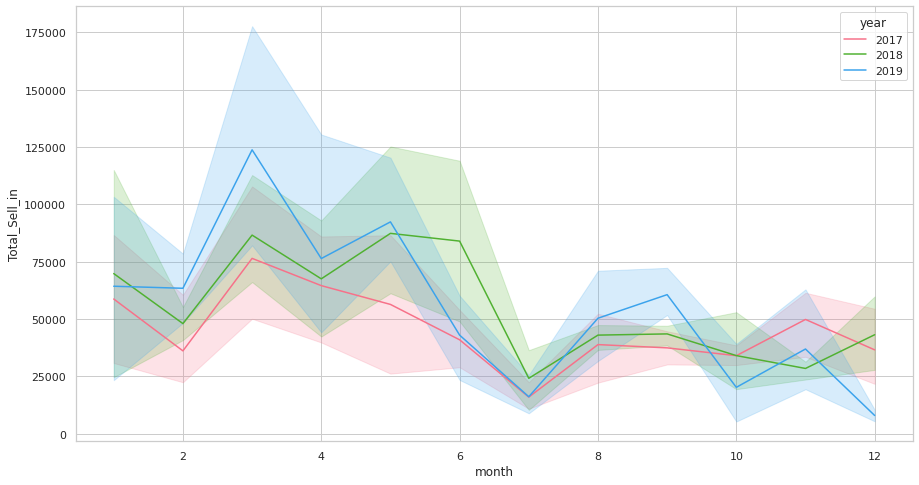

In [ ]:
fig = plt.figure(figsize=(15,8))
sns.set(style='whitegrid')
#plt.style.use('fast')
sns.lineplot(x='month', y='Total_Sell_in', hue='year',data=df,palette=sns.color_palette("husl", 3));

Between 2 to 4 months the trend is quite similar, betwee 6 to 8 months first it is decreasing than increasing 

In [ ]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

# moving_average(df.Total_Sell_in, )

33360.041666666664

In [ ]:
def plot_moving_avg(series, window, plot_intervals = False, scale=1.96, plot_anomalies=False):


  """
        series - Total_sell_in (df[['Total_Sell_in']]) 
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

  """
  rolling_mean = series.rolling(window=window).mean()
  plt.figure(figsize=(15,8))
  plt.title("Moving average\n window size = {}".format(window))
  plt.plot(rolling_mean, "r", label="Rolling mean trend")


  # Plot confidence intervals for smoothed values
  if plot_intervals:
    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window:] - rolling_mean[window:])
    lower_bond = rolling_mean - (mae + scale * deviation)
    upper_bond = rolling_mean + (mae + scale * deviation)
    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
        
  # Having the intervals, find abnormal values
  if plot_anomalies:
    anomalies = pd.DataFrame(index=series.index, columns=series.columns)
    anomalies[series<lower_bond] = series[series<lower_bond]
    anomalies[series>upper_bond] = series[series>upper_bond]
    plt.plot(anomalies, "ro", markersize=10)
        
  plt.plot(series[window:], label="Actual values")
  plt.legend(loc="upper left")
  plt.grid(True)



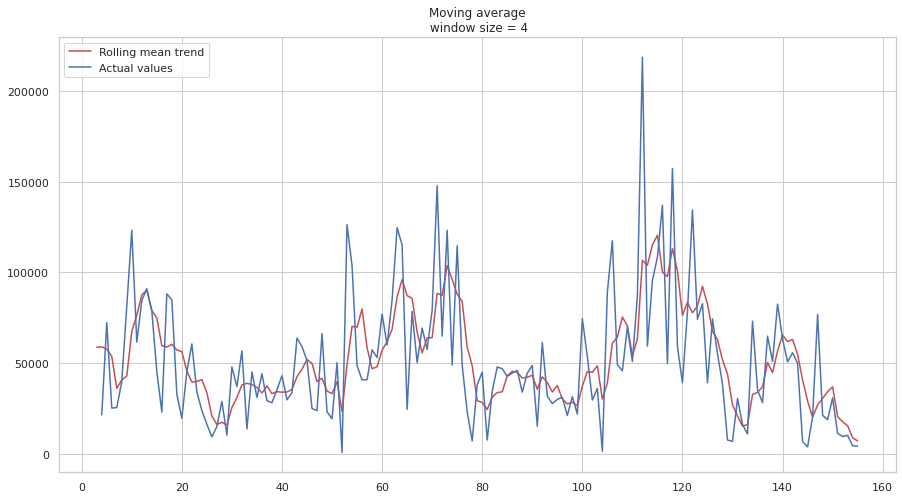

In [ ]:
plot_moving_avg(df.Total_Sell_in, 4) 


Monthly trend

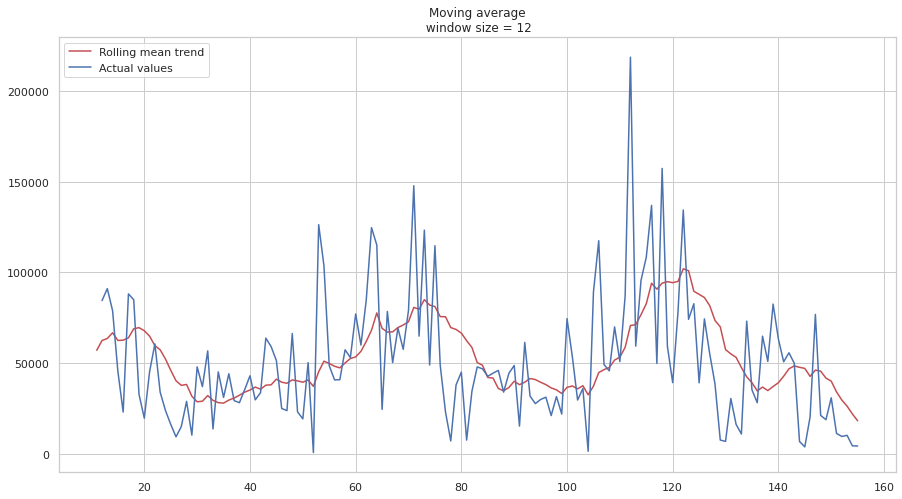

In [ ]:
plot_moving_avg(df.Total_Sell_in, 12) 

    

Quatarly Trend

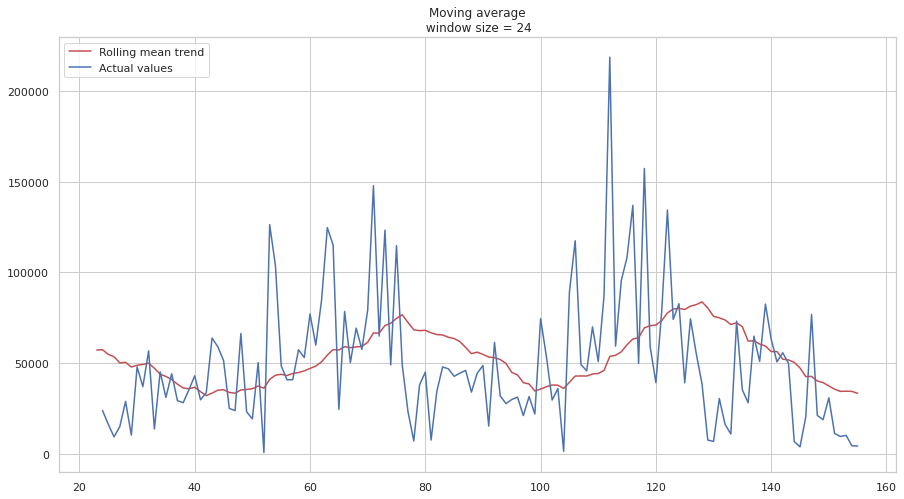

In [ ]:
plot_moving_avg(df.Total_Sell_in, 24) 


Half yearly trend

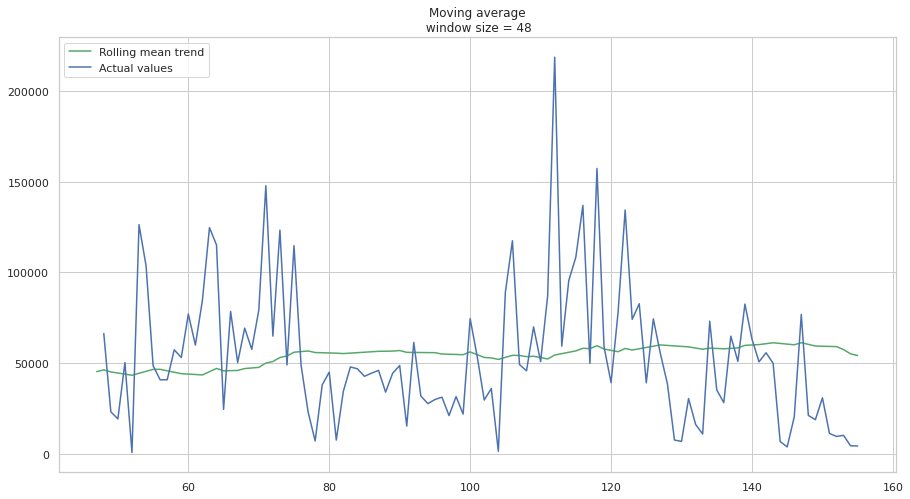

In [ ]:
plot_moving_avg(df.Total_Sell_in, 48) 


yearly trend

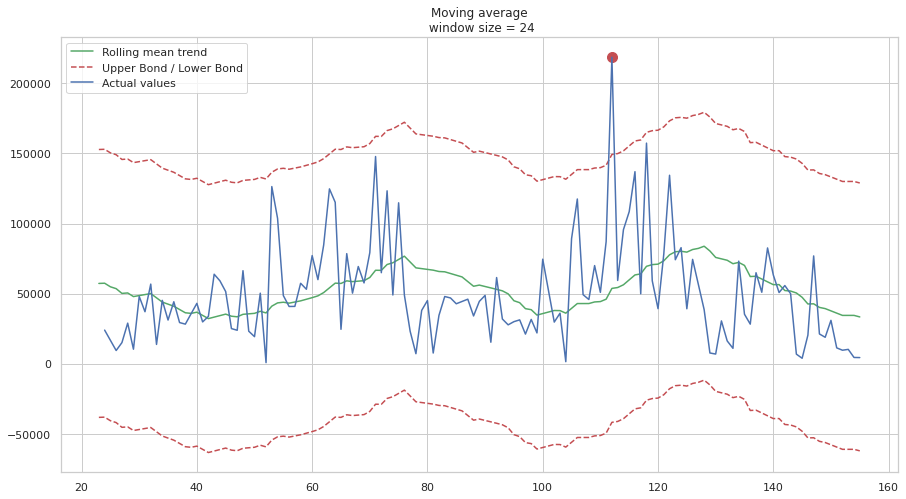

In [ ]:
plot_moving_avg(df[['Total_Sell_in']], 24, plot_intervals=True, plot_anomalies=True) 


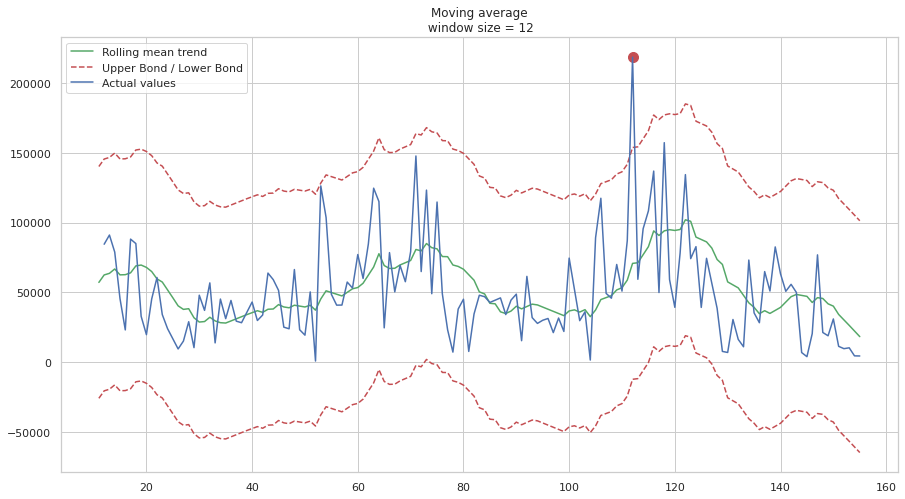

In [ ]:
plot_moving_avg(df[['Total_Sell_in']], 12, plot_intervals=True, plot_anomalies=True) 


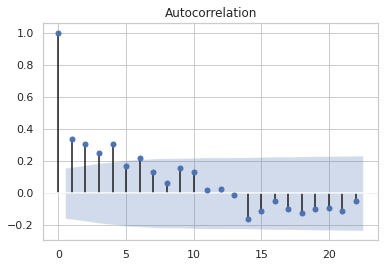

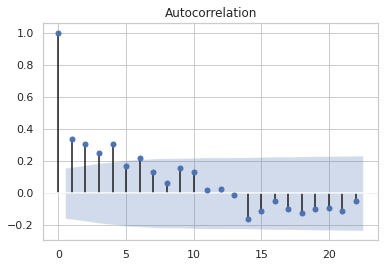

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df['Total_Sell_in'])

In [ ]:
result = adfuller(df['Total_Sell_in'])
print('ADF characteristic', result[0])
print('p-value', result[1])

ADF characteristic -3.247860825713929
p-value 0.017376159841397315


In [ ]:
diff_1st = df.diff(periods=1)

In [ ]:
diff_1st = diff_1st[1:]


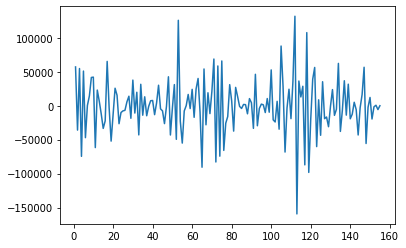

In [ ]:
plt.plot(diff_1st['Total_Sell_in'])

In [ ]:
result = adfuller(diff_1st['Total_Sell_in'].dropna())
print('ADF characteristic', result[0])
print('p-value', result[1])

ADF characteristic -8.486256830930207
p-value 1.3507871234061438e-13


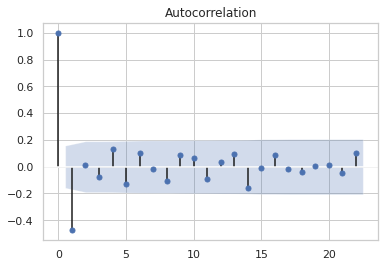

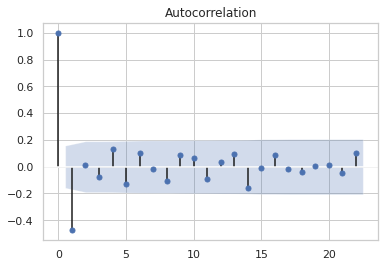

In [ ]:
plot_acf(diff_1st['Total_Sell_in'])

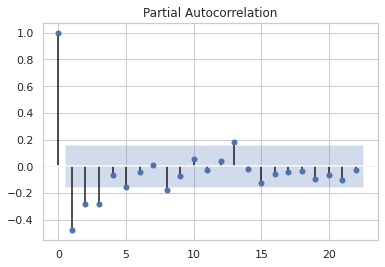

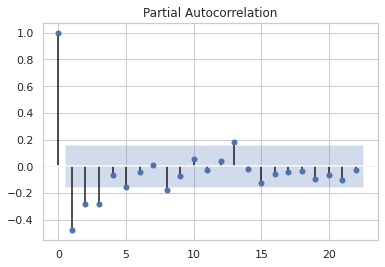

In [ ]:
plot_pacf(diff_1st['Total_Sell_in'])

In [ ]:
X = df['Total_Sell_in'].values
train = X[:130]
test = X[130:]

In [ ]:
from statsmodels.tsa.arima_model import ARIMA


In [ ]:
model_arima = ARIMA(train, order=(4,2,4))
model_arima_fit = model_arima.fit()

In [ ]:
predictions = model_arima_fit.forecast(steps=26)[0]

In [ ]:
predictions

array([43468.27007873, 50219.6901329 , 44663.99407907, 40848.46248756,
       50066.45949394, 41065.87343317, 43636.0855959 , 47209.94488349,
       39839.0968405 , 45070.10553328, 43956.70523115, 40069.40470666,
       44892.63121722, 41310.57751443, 40749.81370934, 43499.28871111,
       39629.02302561, 41109.16439752, 41538.95809652, 38760.19818315,
       40790.48644005, 39577.88868623, 38306.82279081, 39807.89512361,
       37931.6123355 , 37869.01623738])

In [ ]:
train_pred = model_arima_fit.predict(start=2, end=129)

In [ ]:

d1 = list(train_pred)
d2 = list(predictions)

In [ ]:

d1.extend(d2)

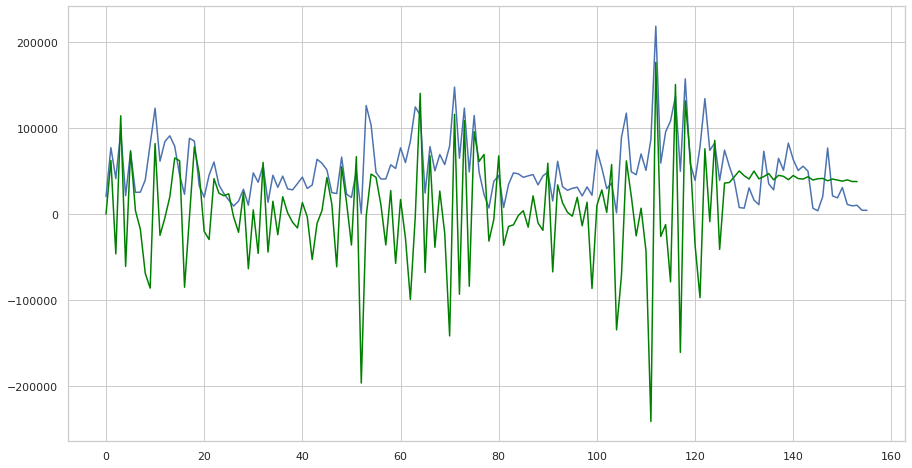

In [ ]:

plt.figure(figsize=(15,8))
plt.plot(df['Total_Sell_in'].values)
plt.plot(d1, color='green')

In [ ]:
print('MSE on Training:', mean_absolute_error(train[2:], train_pred))
print('MSE on Testing :', mean_absolute_error(test, predictions))


MSE on Training: 67402.62016245892
MSE on Testing : 23355.12651263171


In [ ]:

predictions

array([43468.27007873, 50219.6901329 , 44663.99407907, 40848.46248756,
       50066.45949394, 41065.87343317, 43636.0855959 , 47209.94488349,
       39839.0968405 , 45070.10553328, 43956.70523115, 40069.40470666,
       44892.63121722, 41310.57751443, 40749.81370934, 43499.28871111,
       39629.02302561, 41109.16439752, 41538.95809652, 38760.19818315,
       40790.48644005, 39577.88868623, 38306.82279081, 39807.89512361,
       37931.6123355 , 37869.01623738])

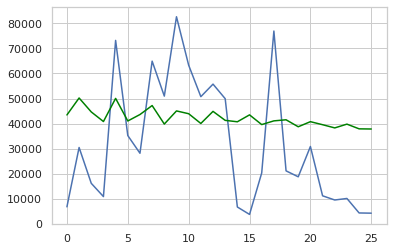

In [ ]:
plt.plot(test)
plt.plot(predictions, color='green')

In [ ]:
import itertools
p=d=q = range(0,5)
pdq = list(itertools.product(p,d,q))


In [ ]:
for parm in pdq:

  try:
    model_arima = ARIMA(train, order=parm)
    model_arima_fit = model_arima.fit()
    print(parm,model_arima_fit.aic)

  except:
    continue

(0, 0, 0) 3097.682881602815
(0, 0, 1) 3092.2172341109094
(0, 0, 2) 3089.2116596064225
(0, 0, 3) 3090.2639836694843
(0, 0, 4) 3083.9149382209453
(0, 1, 0) 3119.890571439327
(0, 1, 1) 3062.480790012823
(0, 1, 2) 3064.455875120399
(0, 2, 0) 3235.3578396868265
(0, 2, 1) 3103.5042401961496
(1, 0, 0) 3088.8608957319793
(1, 0, 1) 3080.7225556797275
(1, 1, 0) 3086.685985373999
(1, 1, 1) 3064.4558210117625
(1, 1, 2) 3065.4372509945765
(1, 1, 3) 3067.100285624108
(1, 1, 4) 3067.4223990023447
(1, 2, 0) 3159.734609403648


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 2, 3) 3052.3208864232433
(1, 2, 4) 3054.111671078625
(2, 0, 0) 3085.0677292531363
(2, 0, 1) 3082.5452118534477
(2, 0, 2) 3083.5000880272155
(2, 1, 0) 3079.3454137884382
(2, 1, 1) 3066.455321023343
(2, 1, 2) 3067.200759316093
(2, 1, 3) 3063.4181831268893
(2, 1, 4) 3064.7554442366663
(2, 2, 0) 3135.5726429958404
(2, 2, 1) 3064.519544810817
(2, 2, 4) 3053.1038217755017
(3, 0, 0) 3085.8345672208593
(3, 0, 1) 3084.516697502547
(3, 0, 2) 3085.4442801266446
(3, 0, 4) 3082.647050886769
(3, 1, 0) 3068.680331281783
(3, 1, 1) 3067.468732781399
(3, 1, 2) 3068.0087075221254


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


(3, 1, 4) 3067.865370438695
(3, 2, 0) 3104.9434227143797


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(3, 2, 1) 3054.5266120234623
(3, 2, 2) 3054.109604855194


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(3, 2, 4) 3054.9602295801674
(4, 0, 0) 3082.4028783041363
(4, 0, 1) 3084.187688982843
(4, 0, 2) 3085.5871859403037
(4, 0, 3) 3082.698134000321
(4, 0, 4) 3085.877887672913
(4, 1, 0) 3070.1276370197993


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(4, 1, 1) 3064.322529863658
(4, 1, 2) 3066.10106675381


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(4, 1, 3) 3066.7629288043568


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(4, 1, 4) 3064.564754561546
(4, 2, 0) 3098.4508311618074
(4, 2, 1) 3056.094613615639
(4, 2, 2) 3055.3874621706027
(4, 2, 3) 3056.496816428974
(4, 2, 4) 3053.556130051087


# Auto-ARIMA

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 6.6MB/s 
     |████████████████████████████████| 9.5MB 14.7MB/s 
     |████████████████████████████████| 2.1MB 47.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [ ]:
import pmdarima as pm

In [ ]:
X = df['Total_Sell_in'].values
train = X[:130]
test = X[130:]

In [ ]:
model = pm.auto_arima(train,scoring= mean_absolute_percentage_error)
model.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 2), out_of_sample_size=0,
      scoring=<function mean_absolute_percentage_error at 0x7fd031a0e6a8>,
      scoring_args={}, seasonal_order=(0, 0, 0, 0), start_params=None,
      suppress_warnings=True, trend=None, with_intercept=True)

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  130
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1535.958
Date:                Sun, 06 Dec 2020   AIC                           3083.916
Time:                        12:43:28   BIC                           3101.121
Sample:                             0   HQIC                          3090.907
                                - 130                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.914e+04   1.37e+04      1.397      0.162   -7707.636     4.6e+04
ar.L1         -0.0912      0.234     -0.390      0.696      -0.549       0.367
ar.L2          0.7457      0.229      3.253      0.001       0.296       1.195
ma.L1          0.2698      0.262      1.029      0.303      -0.244       0.784
ma.L2         -0.5089      0.277     -1.834      0.067      -1.053       0.035
sigma2      1.066e+09      0.231   4.61e+09      0.000    1.07e+09    1.07e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               107.27
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.31   Skew:                             1.39
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.67e+25. Standard errors may be unstable.
"""

In [ ]:
forecast = model.predict(n_periods=len(test))

In [ ]:
forecast

array([50113.58333006, 41769.3959905 , 52705.92699233, 45486.03427571,
       54300.2480706 , 48112.31785212, 55249.72420047, 49984.27601222,
       55787.09456   , 51331.27826455, 56065.00786626, 52310.4562783 ,
       56182.97287998, 53029.91635722, 56205.33994874, 53564.4103538 ,
       56173.28167932, 53965.92970082, 56112.7614331 , 54270.879239  ,
       56039.82163655, 54504.944841  , 55964.08365152, 54686.404277  ,
       55891.05588036, 54828.38580834])

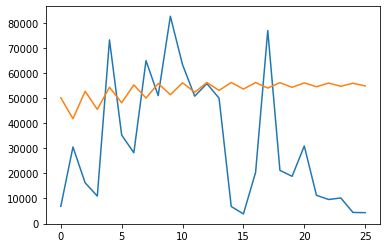

In [ ]:
plt.plot(test)
plt.plot(forecast)

In [ ]:
forecast_df = pd.DataFrame(forecast,index=test_df.index, columns=['prediction'])

In [ ]:
test_df = df[130:]

In [ ]:
test_df = test_df.set_index('Week')

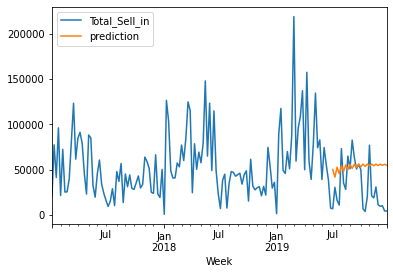

In [ ]:
pd.concat([data['Total_Sell_in'], forecast_df],axis=1).plot()


# ARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
import statsmodels.api as sm


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


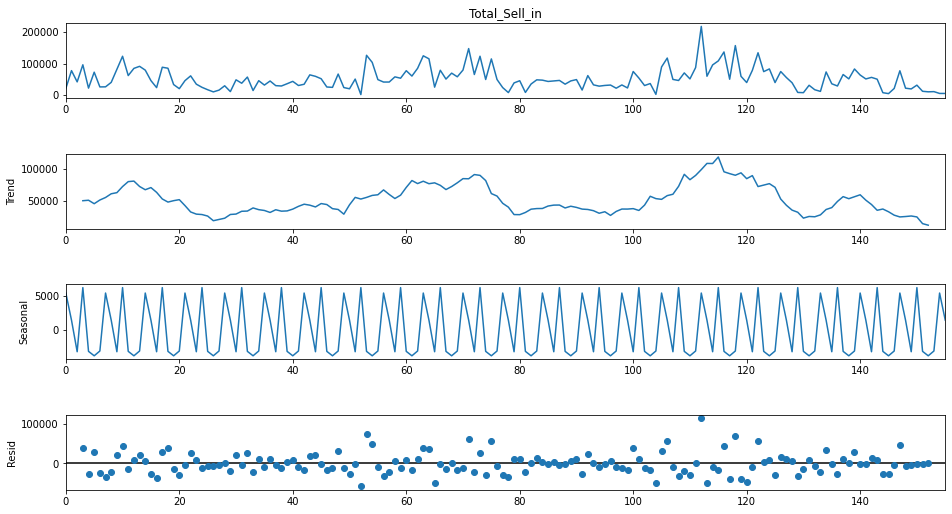

In [ ]:
res = sm.tsa.seasonal_decompose(df.Total_Sell_in.dropna(),freq=7)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [ ]:
train_df = df[:130]
test_df = df[130:]

In [ ]:
arimax = SARIMAX(train_df['Total_Sell_in'], order=(3,2,2))
arimax = arimax.fit()
pred = arimax.predict(130,155)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



In [ ]:
weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred)

79.41688017300541

In [ ]:
x.add_row(["ARIMAX", "Total_Sell_in", 'Nan', np.round(weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred),2)])

In [ ]:
arimax = SARIMAX(train_df['Total_Sell_in'], order=(3,2,2), exog=train_df['Sentiment Lag 0'])

In [ ]:
arimax = arimax.fit()

In [ ]:
pred = arimax.predict(130,155,exog= test_df['Sentiment Lag 0'].values.reshape(26,1))

In [ ]:
weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred)

79.84124364365522

In [ ]:
x.add_row(["ARIMAX", "Total_Sell_in", 'Sentiment lag 0', np.round(weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred),2)])

In [ ]:
arimax = SARIMAX(train_df['Total_Sell_in'], order=(3,2,2), exog=train_df['Sentiment Lag 1'])
arimax = arimax.fit()
pred = arimax.predict(130,155,exog=test_df['Sentiment Lag 1'].values.reshape(26,1))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



In [ ]:
weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred)

78.19597735679174

In [ ]:
x.add_row(["ARIMAX", "Total_Sell_in", 'Sentiment lag 1', np.round(weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred),2)])

In [ ]:
arimax = SARIMAX(train_df['Total_Sell_in'], order=(3,2,2), exog=train_df['Sentiment Lag 2'])
arimax = arimax.fit()
pred = arimax.predict(130,155,exog=test_df['Sentiment Lag 2'].values.reshape(26,1))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [ ]:
weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred)

84.62278280474347

In [ ]:
x.add_row(["ARIMAX", "Total_Sell_in", 'Sentiment lag 2', np.round(weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred),2)])

In [ ]:
arimax = SARIMAX(train_df['Total_Sell_in'], order=(3,2,2), exog=train_df['Sentiment Lag 3'])
arimax = arimax.fit()
pred = arimax.predict(130,155,exog=test_df['Sentiment Lag 3'].values.reshape(26,1))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



In [ ]:
weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred)

72.6227126963557

In [ ]:
x.add_row(["ARIMAX", "Total_Sell_in", 'Sentiment lag 3', np.round(weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred),2)])

In [ ]:
arimax = SARIMAX(train_df['Total_Sell_in'], order=(3,2,2), exog=train_df['Sentiment Lag 4'])
arimax = arimax.fit()
pred = arimax.predict(130,155,exog=test_df['Sentiment Lag 4'].values.reshape(26,1))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [ ]:
weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred)

83.32014514877628

In [ ]:
x.add_row(["ARIMAX", "Total_Sell_in", 'Sentiment lag 4', np.round(weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred),2)])

In [ ]:
arimax = SARIMAX(train_df['Total_Sell_in'], order=(3,2,2), exog=train_df['Sentiment Lag 5'])
arimax = arimax.fit()
pred = arimax.predict(130,155,exog=test_df['Sentiment Lag 5'].values.reshape(26,1))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



In [ ]:
weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred)

71.91921956143126

In [ ]:
x.add_row(["ARIMAX", "Total_Sell_in", 'Sentiment lag 0', np.round(weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred),2)])

# SARIMAX

In [ ]:
sarimax = SARIMAX(train_df['Total_Sell_in'], order=(3,2,2),seasonal_order=(0,0,3,5))
sarimax =sarimax.fit(disp=False)
pred = sarimax.predict(130,155)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



In [ ]:
weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred)

80.66511694664952

In [ ]:
x.add_row(["SARIMAX", "Total_Sell_in", 'Nan', np.round(weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred),2)])

In [ ]:
sarimax = SARIMAX(train_df['Total_Sell_in'], order=(3,2,2),seasonal_order=(0,0,3,5), exog=train_df['Sentiment Lag 0'])
sarimax =sarimax.fit(disp=False)
pred = sarimax.predict(130,155, exog = test_df['Sentiment Lag 0'].values.reshape(26,1))


In [ ]:
weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred)

68.92080835735308

In [ ]:
x.add_row(["SARIMAX", "Total_Sell_in", 'Sentiment lag 0', np.round(weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred),2)])

In [ ]:
sarimax = SARIMAX(train_df['Total_Sell_in'], order=(3,2,2),seasonal_order=(0,0,3,5), exog=train_df['Sentiment Lag 1'])
sarimax =sarimax.fit(disp=False)
pred = sarimax.predict(130,155, exog = test_df['Sentiment Lag 1'].values.reshape(26,1))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



In [ ]:
weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred)

78.61886302045255

In [ ]:
x.add_row(["SARIMAX", "Total_Sell_in", 'Sentiment lag 1', np.round(weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred),2)])

In [ ]:
sarimax = SARIMAX(train_df['Total_Sell_in'], order=(3,2,2),seasonal_order=(0,0,3,5), exog=train_df['Sentiment Lag 2'])
sarimax =sarimax.fit(disp=False)
pred = sarimax.predict(130,155, exog = test_df['Sentiment Lag 2'].values.reshape(26,1))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [ ]:
weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred)

85.11075170252191

In [ ]:
x.add_row(["SARIMAX", "Total_Sell_in", 'Sentiment lag 2', np.round(weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred),2)])

In [ ]:
sarimax = SARIMAX(train_df['Total_Sell_in'], order=(3,2,2),seasonal_order=(0,0,3,5), exog=train_df['Sentiment Lag 3'])
sarimax =sarimax.fit(disp=False)
pred = sarimax.predict(130,155, exog = test_df['Sentiment Lag 3'].values.reshape(26,1))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred)

73.32743248577331

In [ ]:
x.add_row(["SARIMAX", "Total_Sell_in", 'Sentiment lag 3', np.round(weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred),2)])

In [ ]:
sarimax = SARIMAX(train_df['Total_Sell_in'], order=(3,2,2),seasonal_order=(0,0,3,5), exog=train_df['Sentiment Lag 4'])
sarimax =sarimax.fit(disp=False)
pred = sarimax.predict(130,155, exog = test_df['Sentiment Lag 4'].values.reshape(26,1))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



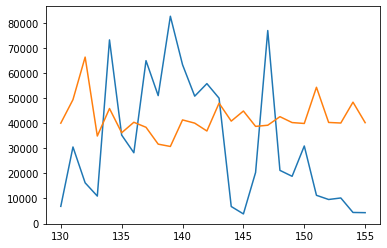

In [ ]:
plt.plot(test_df['Total_Sell_in'])
plt.plot(pred)

In [ ]:
weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred)

81.60297494194536

In [ ]:
x.add_row(["SARIMAX", "Total_Sell_in", 'Sentiment lag 4', np.round(weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred),2)])

In [ ]:
sarimax = SARIMAX(train_df['Total_Sell_in'], order=(3,2,2),seasonal_order=(0,0,3,5), exog=train_df['Sentiment Lag 5'])
sarimax =sarimax.fit(disp=False)
pred = sarimax.predict(130,155, exog = test_df['Sentiment Lag 5'].values.reshape(26,1))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred)

74.82399511083136

In [ ]:
x.add_row(["SARIMAX", "Total_Sell_in", 'Sentiment lag 5', np.round(weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], pred),2)])

# FB ProPHET

In [ ]:
prophet_df = train_df[['Week', 'Total_Sell_in']]

In [ ]:
prophet_df = prophet_df.rename(columns={'Week':'ds', 'Total_Sell_in':'y'})

In [ ]:
from fbprophet import Prophet


In [ ]:
m = Prophet()
m.fit(prophet_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods = 26, freq='W')
forecast = m.predict(future)


In [ ]:
forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
126,2019-06-09,62163.256455,40902.766726,105431.675470,62163.256455,62163.256455,10222.027493,10222.027493,10222.027493,10222.027493,10222.027493,10222.027493,0.0,0.0,0.0,72385.283948
127,2019-06-16,62334.847362,36198.919142,105116.613747,62334.847362,62334.847362,6499.848823,6499.848823,6499.848823,6499.848823,6499.848823,6499.848823,0.0,0.0,0.0,68834.696185
128,2019-06-23,62506.438269,19172.977261,89694.472136,62506.438269,62506.438269,-8891.669437,-8891.669437,-8891.669437,-8891.669437,-8891.669437,-8891.669437,0.0,0.0,0.0,53614.768832
129,2019-06-30,62678.029177,683.640842,67836.965576,62678.029177,62678.029177,-29256.736328,-29256.736328,-29256.736328,-29256.736328,-29256.736328,-29256.736328,0.0,0.0,0.0,33421.292849
130,2019-07-07,62849.620084,-12214.965175,56107.393598,62849.620084,62849.620084,-40050.109696,-40050.109696,-40050.109696,-40050.109696,-40050.109696,-40050.109696,0.0,0.0,0.0,22799.510388
131,2019-07-14,63021.210991,-6586.009198,60100.132921,63021.147954,63021.328752,-35556.302082,-35556.302082,-35556.302082,-35556.302082,-35556.302082,-35556.302082,0.0,0.0,0.0,27464.908909
132,2019-07-21,63192.801898,5251.648036,74161.326352,63192.590258,63193.117462,-24313.775804,-24313.775804,-24313.775804,-24313.775804,-24313.775804,-24313.775804,0.0,0.0,0.0,38879.026095
133,2019-07-28,63364.392806,10641.705869,82461.979326,63363.933275,63364.939227,-17637.922328,-17637.922328,-17637.922328,-17637.922328,-17637.922328,-17637.922328,0.0,0.0,0.0,45726.470477
134,2019-08-04,63535.983713,11985.814268,77892.807952,63535.316033,63536.895199,-16888.572204,-16888.572204,-16888.572204,-16888.572204,-16888.572204,-16888.572204,0.0,0.0,0.0,46647.411509
135,2019-08-11,63707.574620,15158.711115,81646.226317,63706.642026,63708.829097,-15151.505673,-15151.505673,-15151.505673,-15151.505673,-15151.505673,-15151.505673,0.0,0.0,0.0,48556.068947


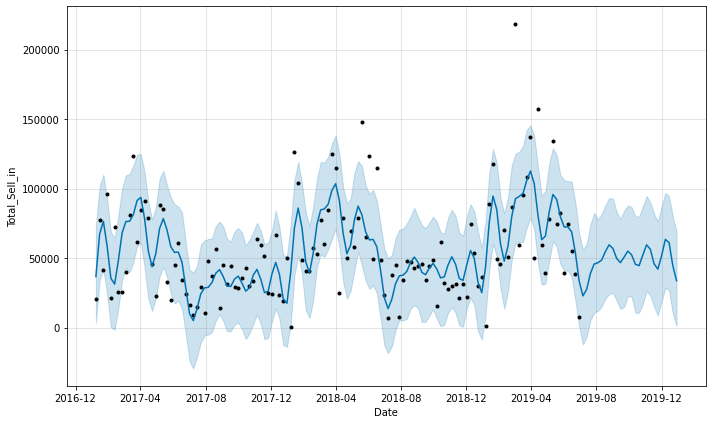

In [ ]:
figure = m.plot(forecast, xlabel='Date', ylabel='Total_Sell_in')

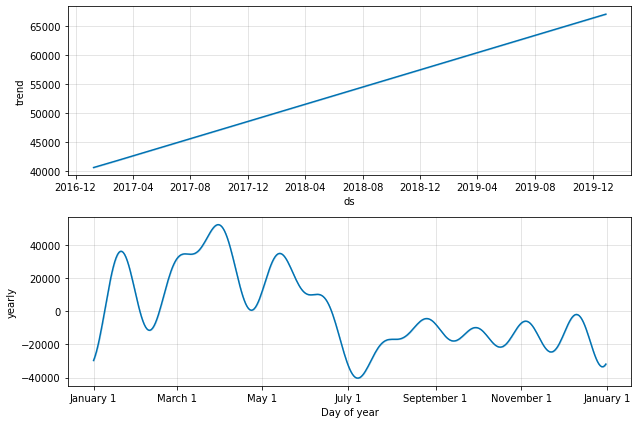

In [ ]:
figure2 = m.plot_components(forecast)

In [ ]:

forecast_metric(test_df['Total_Sell_in'],forecast['yhat'][130:],model_used='Fbprophet',prim_col='Total_Sell_in',seco_col='Nan')

WMAPE 74.35822105410135
RMSE 28519.783364407398
R2_square -0.31676988467991873
MAE 23966.569823842146


In [ ]:
weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'],forecast['yhat'])

74.35822105410136

In [ ]:
x.add_row(["FBProphet", "Total_Sell_in", 'Nan', np.round(weighted_mean_absolute_percentage_error(test_df['Total_Sell_in'], forecast['yhat']),2)])

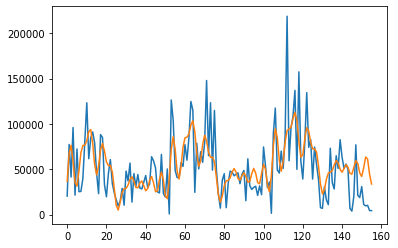

In [ ]:
plt.plot(df['Total_Sell_in'])
plt.plot(forecast['yhat'])

In [ ]:
x

In [ ]:
!pip install prettytable

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()

In [ ]:
x.field_names = ["Model", "Primary_Column", "Secondary_Column", "WMAPE","RMSE","R2 Squared", "MAE"]


In [ ]:
Gridsearch for all above
more metrics: rmse, map, r2
moving average baseline
lstm
monthly/biweekly predictions


# MA

In [ ]:
def forecast_metric(ytrue, pred,model_used=None, prim_col=None, seco_col=None, X=x):
  '''
  ytrue - series of true of value
  pred - list of predictions
  model_used - model used
  prim col - primary column used
  seco_col = secondary column used
  X - table to store results
  '''


  WMAPE = weighted_mean_absolute_percentage_error(ytrue, pred)
  RMSE = np.sqrt(mean_squared_error(ytrue, pred))
  R2_sq = r2_score(ytrue, pred)
  MAE = mean_absolute_error(ytrue, pred) 

  print('WMAPE',WMAPE)
  print('RMSE', RMSE)
  print('R2_square', R2_sq)
  print('MAE', MAE)

  X.add_row([model_used, prim_col, seco_col, np.round(WMAPE,2), np.round(RMSE,2), np.round(R2_sq,2), np.round(MAE,2)])
  


In [ ]:
from statsmodels.tsa.arima_model import ARMA

In [ ]:
MA = ARMA(train_df['Total_Sell_in'], order=(0,2))
MA = MA.fit()
pred = MA.predict(130,155)

In [ ]:
forecast_metric(test_df['Total_Sell_in'],pred,model_used='MA',prim_col='Total_Sell_in',seco_col='Nan')

WMAPE 89.25610174372648
RMSE 33051.10568387668
R2_square -0.7684363227329589
MAE 28768.34012863989


GRid Search ARIMA

In [ ]:
def Grid_ARIMA(p,q,d,exog=None):
  '''
    p is list of p values
    q is list of q values
    d is list of d values
    exog is exog feature 

  ''' 
  best_aic  = np.inf
  best_order = None
  best_model = None

  for i in p:
    for j in q:
      for k in d:

        try:
          temp_model = SARIMAX(train_df['Total_Sell_in'],order=(i,j,k), exog=None)
          temp_model = temp_model.fit()
          temp_aic = temp_model.aic
          if temp_aic < best_aic:
            best_aic = temp_aic
            best_order = (i,j,k)
            best_model = temp_model
        
        except:
          continue

  return best_aic, best_order, best_model

In [ ]:
p=list(range(6))
q= list(range(6))
d = list(range(3))



In [ ]:
Grid_ARIMA(p,q,d)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3047.4679915068946,
 (0, 2, 2),
 <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f7daac2a470>)

In [ ]:
arimax = SARIMAX(train_df['Total_Sell_in'], order=(3,1,3))
arimax = arimax.fit(disp=False)
pred = arimax.predict(130,155)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
forecast_metric(test_df['Total_Sell_in'],pred,model_used='ARIMA',prim_col='Total_Sell_in',seco_col='Nan')

WMAPE 80.58008650751192
RMSE 29286.11718862955
R2_square -0.3884844890637771
MAE 25971.953636281953


In [ ]:
arimax = SARIMAX(train_df['Total_Sell_in'], order=(3,1,3), exog=train_df['Sentiment Lag 0'])
arimax = arimax.fit()
pred = arimax.predict(130,155,exog=test_df['Sentiment Lag 0'].values.reshape(26,1))
forecast_metric(test_df['Total_Sell_in'],pred,model_used='ARIMAX',prim_col='Total_Sell_in',seco_col='Sentiment Lag 0')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



WMAPE 81.48759169903441
RMSE 29790.314636495303
R2_square -0.436705059115887
MAE 26264.45372880432


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
arimax = SARIMAX(train_df['Total_Sell_in'], order=(3,1,3), exog=train_df['Sentiment Lag 1'])
arimax = arimax.fit()
pred = arimax.predict(130,155,exog=test_df['Sentiment Lag 1'].values.reshape(26,1))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
forecast_metric(test_df['Total_Sell_in'],pred,model_used='ARIMAX',prim_col='Total_Sell_in',seco_col='Sentiment Lag 1')

WMAPE 80.40771173110731
RMSE 29427.757035902032
R2_square -0.40194754433548185
MAE 25916.395124311042


In [ ]:
arimax = SARIMAX(train_df['Total_Sell_in'], order=(3,1,3), exog=train_df['Sentiment Lag 2'])
arimax = arimax.fit()
pred = arimax.predict(130,155,exog=test_df['Sentiment Lag 2'].values.reshape(26,1))
forecast_metric(test_df['Total_Sell_in'],pred,model_used='ARIMAX',prim_col='Total_Sell_in',seco_col='Sentiment Lag 2')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



WMAPE 83.9618409220674
RMSE 31089.271283905593
R2_square -0.5647268173474891
MAE 27061.934705685977


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
arimax = SARIMAX(train_df['Total_Sell_in'], order=(3,1,3), exog=train_df['Sentiment Lag 3'])
arimax = arimax.fit()
pred = arimax.predict(130,155,exog=test_df['Sentiment Lag 3'].values.reshape(26,1))
forecast_metric(test_df['Total_Sell_in'],pred,model_used='ARIMAX',prim_col='Total_Sell_in',seco_col='Sentiment Lag 3')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



WMAPE 76.80349512040989
RMSE 28212.49415921847
R2_square -0.28854741834650954
MAE 24754.711751094208


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
arimax = SARIMAX(train_df['Total_Sell_in'], order=(3,1,3), exog=train_df['Sentiment Lag 4'])
arimax = arimax.fit()
pred = arimax.predict(130,155,exog=test_df['Sentiment Lag 4'].values.reshape(26,1))
forecast_metric(test_df['Total_Sell_in'],pred,model_used='ARIMAX',prim_col='Total_Sell_in',seco_col='Sentiment Lag 4')

WMAPE 83.60770895880727
RMSE 30537.93809521868
R2_square -0.5097215753533881
MAE 26947.793615379996


In [ ]:
arimax = SARIMAX(train_df['Total_Sell_in'], order=(3,1,3), exog=train_df['Sentiment Lag 5'])
arimax = arimax.fit()
pred = arimax.predict(130,155,exog=test_df['Sentiment Lag 5'].values.reshape(26,1))
forecast_metric(test_df['Total_Sell_in'],pred,model_used='ARIMAX',prim_col='Total_Sell_in',seco_col='Sentiment Lag 5')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



WMAPE 77.64318210938262
RMSE 28593.486467320843
R2_square -0.32358448262397954
MAE 25025.35320224921


In [ ]:

from itertools import product                    
from tqdm import tqdm_notebook

In [ ]:
ps = range(0, 4)
d= range(0,3)
qs = range(0, 4)
Ps = range(0, 4 )
D= range(0,2)
Qs = range(0, 4)
s = 5 # season length

# creating list with all the possible combinations of parameters
parameters = product(ps,d,qs,Ps,D,Qs)
parameters_list = list(parameters)
len(parameters_list)

1536

In [ ]:
def optimizeSARIMA(parameters_list, s):
  
    
    results = []
    best_aic = np.inf
    best_model = None
    best_param =None

    for param in tqdm_notebook(parameters_list):
        
        try:
            model=SARIMAX(train_df['Total_Sell_in'], order=(param[0], param[1], param[2]),seasonal_order=(param[3], param[4], param[5], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic

        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table,best_param,best_model,best_aic

In [ ]:
optimizeSARIMA(parameters_list,5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed

,parameters,aic
0,"(3, 2, 3, 0, 1, 1)",2967.241186
1,"(3, 2, 3, 1, 1, 2)",2968.045557
2,"(3, 1, 2, 1, 1, 1)",2972.254243
3,"(3, 1, 2, 1, 1, 2)",2972.411650
4,"(3, 2, 3, 1, 1, 1)",2972.481751
...,...,...
1529,"(0, 2, 0, 1, 0, 3)",3239.387549
1530,"(0, 2, 0, 2, 0, 3)",3241.484563
1531,"(0, 2, 0, 3, 0, 3)",3241.831617
1532,"(0, 0, 0, 0, 0, 0)",3254.956709


In [ ]:
3,2,3, 0,1,1

In [ ]:
sarimax = SARIMAX(train_df['Total_Sell_in'], order=(3,1,3),seasonal_order=(0,1,1,5))
sarimax =sarimax.fit(disp=False)
pred = sarimax.predict(130,155)
forecast_metric(test_df['Total_Sell_in'],pred,model_used='SARIMA',prim_col='Total_Sell_in',seco_col='Nan')

WMAPE 68.0650115403552
RMSE 25368.89631211862
R2_square -0.04188692420997531
MAE 21938.19094267544


In [ ]:
sarimax = SARIMAX(train_df['Total_Sell_in'], order=(3,1,3),seasonal_order=(0,1,1,5), exog=train_df['Sentiment Lag 0'])
sarimax = sarimax.fit()
pred = sarimax.predict(130,155,exog=test_df['Sentiment Lag 0'].values.reshape(26,1))
forecast_metric(test_df['Total_Sell_in'],pred,model_used='SARIMAX',prim_col='Total_Sell_in',seco_col='Sentiment Lag 0')

WMAPE 69.62098785164083
RMSE 25918.9245342012
R2_square -0.0875554151875968
MAE 22439.70125828047


In [ ]:
sarimax = SARIMAX(train_df['Total_Sell_in'], order=(3,1,3),seasonal_order=(0,1,1,5), exog=train_df['Sentiment Lag 1'])
sarimax = sarimax.fit()
pred = sarimax.predict(130,155,exog=test_df['Sentiment Lag 1'].values.reshape(26,1))
forecast_metric(test_df['Total_Sell_in'],pred,model_used='SARIMAX',prim_col='Total_Sell_in',seco_col='Sentiment Lag 1')

WMAPE 67.41083074117633
RMSE 25483.333980756925
R2_square -0.051307912143225165
MAE 21727.340419644097


In [ ]:
sarimax = SARIMAX(train_df['Total_Sell_in'], order=(3,1,3),seasonal_order=(0,1,1,5), exog=train_df['Sentiment Lag 2'])
sarimax = sarimax.fit()
pred = sarimax.predict(130,155,exog=test_df['Sentiment Lag 2'].values.reshape(26,1))
forecast_metric(test_df['Total_Sell_in'],pred,model_used='SARIMAX',prim_col='Total_Sell_in',seco_col='Sentiment Lag 2')

WMAPE 69.24092702523706
RMSE 25732.011876900917
R2_square -0.07192630143370615
MAE 22317.20297625882


In [ ]:
sarimax = SARIMAX(train_df['Total_Sell_in'], order=(3,1,3),seasonal_order=(0,1,1,5), exog=train_df['Sentiment Lag 3'])
sarimax = sarimax.fit()
pred = sarimax.predict(130,155,exog=test_df['Sentiment Lag 3'].values.reshape(26,1))
forecast_metric(test_df['Total_Sell_in'],pred,model_used='SARIMAX',prim_col='Total_Sell_in',seco_col='Sentiment Lag 3')

WMAPE 65.93579080394115
RMSE 25042.126541332287
R2_square -0.015219269471022479
MAE 21251.916893535512


In [ ]:
sarimax = SARIMAX(train_df['Total_Sell_in'], order=(3,1,3),seasonal_order=(0,1,1,5), exog=train_df['Sentiment Lag 4'])
sarimax = sarimax.fit()
pred = sarimax.predict(130,155,exog=test_df['Sentiment Lag 4'].values.reshape(26,1))
forecast_metric(test_df['Total_Sell_in'],pred,model_used='SARIMAX',prim_col='Total_Sell_in',seco_col='Sentiment Lag 4')

WMAPE 70.2021318678545
RMSE 26854.791979597037
R2_square -0.16751112093316145
MAE 22627.011127247883


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
sarimax = SARIMAX(train_df['Total_Sell_in'], order=(3,1,3),seasonal_order=(0,1,1,5), exog=train_df['Sentiment Lag 5'])
sarimax = sarimax.fit()
pred = sarimax.predict(130,155,exog=test_df['Sentiment Lag 5'].values.reshape(26,1))
forecast_metric(test_df['Total_Sell_in'],pred,model_used='SARIMAX',prim_col='Total_Sell_in',seco_col='Sentiment Lag 5')

WMAPE 59.77047608492497
RMSE 22586.39055691867
R2_square 0.17413110788354824
MAE 19264.760078800053


In [ ]:
print(x)

+---------+----------------+------------------+-------+----------+------------+----------+
|  Model  | Primary_Column | Secondary_Column | WMAPE |   RMSE   | R2 Squared |   MAE    |
+---------+----------------+------------------+-------+----------+------------+----------+
|    MA   | Total_Sell_in  |       Nan        | 89.26 | 33051.11 |   -0.77    | 28768.34 |
|  ARIMA  | Total_Sell_in  |       Nan        | 80.58 | 29286.12 |   -0.39    | 25971.95 |
|  ARIMAX | Total_Sell_in  | Sentiment Lag 0  | 81.49 | 29790.31 |   -0.44    | 26264.45 |
|  ARIMAX | Total_Sell_in  | Sentiment Lag 1  | 80.41 | 29427.76 |    -0.4    | 25916.4  |
|  ARIMAX | Total_Sell_in  | Sentiment Lag 2  | 83.96 | 31089.27 |   -0.56    | 27061.93 |
|  ARIMAX | Total_Sell_in  | Sentiment Lag 3  |  76.8 | 28212.49 |   -0.29    | 24754.71 |
|  ARIMAX | Total_Sell_in  | Sentiment Lag 4  | 83.61 | 30537.94 |   -0.51    | 26947.79 |
|  ARIMAX | Total_Sell_in  | Sentiment Lag 5  | 77.64 | 28593.49 |   -0.32    | 25025.35 |

In [ ]:
model name change
wape>100 ?
regression file model 
fb with sentiments

In [ ]:
https://futurice.com/blog/business-forecasting-with-facebook-prophet
regression file
fb with more variables
lstm 5 more 

In [ ]:
test_df

# linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression


In [ ]:
data = df.dropna(axis=0)

In [ ]:
data.head()

,Week,Total_Sell_in,Total_Sell_in1,Total_Sell_in2,Total_Sell_in3,Total_Sell_in4,Total_Sell_in5,Sentiment Lag 0,Sentiment Lag 1,Sentiment Lag 2,Sentiment Lag 3,Sentiment Lag 4,Sentiment Lag 5,Google Trends Lag 0,Google Trends Lag 1,Google Trends Lag 2,Google Trends Lag 3,Google Trends Lag 4,Google Trends Lag 5
0,2017-01-08,20319.0,0.0,0.0,0.0,0.0,0.0,0.994660,0.998213,0.999767,0.998217,0.612424,0.928982,63,48,96,45,56,69
1,2017-01-15,77327.0,20319.0,0.0,0.0,0.0,0.0,0.180219,0.994660,0.998213,0.999767,0.998217,0.612424,44,63,48,96,45,56
2,2017-01-22,41367.0,77327.0,20319.0,0.0,0.0,0.0,0.996948,0.180219,0.994660,0.998213,0.999767,0.998217,50,44,63,48,96,45
3,2017-01-29,96033.0,41367.0,77327.0,20319.0,0.0,0.0,0.606942,0.996948,0.180219,0.994660,0.998213,0.999767,35,50,44,63,48,96
4,2017-02-05,21446.0,96033.0,41367.0,77327.0,20319.0,0.0,0.711777,0.606942,0.996948,0.180219,0.994660,0.998213,56,35,50,44,63,48


In [ ]:
train_data = data[:130]
test_data = data[130:]

In [ ]:
LR = LinearRegression()
LR = LR.fit(train_data[['Total_Sell_in1','Total_Sell_in2', 'Total_Sell_in3', 'Total_Sell_in4']], train_df['Total_Sell_in'])

In [ ]:
pred = LR.predict(test_data[['Total_Sell_in1','Total_Sell_in2', 'Total_Sell_in3', 'Total_Sell_in4']])

In [ ]:
forecast_metric(test_data['Total_Sell_in'],pred,model_used='Linear_Regression',prim_col='Total_Sell_in1 to 4,',seco_col='Nan')

WMAPE 64.12237964852135
RMSE 24827.13702549791
R2_square 0.004600717307908231
MAE 21383.225820523898


In [ ]:
LR = LinearRegression()
LR = LR.fit(train_data[['Total_Sell_in1','Total_Sell_in2', 'Total_Sell_in3', 'Total_Sell_in4','Sentiment Lag 5']], train_df['Total_Sell_in'])

In [ ]:
pred = LR.predict(test_data[['Total_Sell_in1','Total_Sell_in2', 'Total_Sell_in3', 'Total_Sell_in4','Sentiment Lag 1']])

In [ ]:
forecast_metric(test_data['Total_Sell_in'],pred,model_used='Linear_Regression',prim_col='Total_Sell_in1 to 4,',seco_col='Sentiment Lag 0')

WMAPE 63.87917685798185
RMSE 24564.359828811495
R2_square 0.025560361428416112
MAE 21302.123712043318


FB Prophet

In [ ]:
from fbprophet import Prophet


In [ ]:
d = df.copy()
d = d.rename(columns={'Week':'ds', 'Total_Sell_in':'y'})

In [ ]:
prophet_df = train_df
prophet_df = prophet_df.rename(columns={'Week':'ds', 'Total_Sell_in':'y'})

In [ ]:
m = Prophet()
m = m.fit(prophet_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods = 26, freq='W')
forecast = m.predict(future)


In [ ]:
forecast_metric(test_df['Total_Sell_in'],forecast['yhat'][130:],model_used='Fb_Prophet',prim_col='Total_Sell_in',seco_col='Nan')

WMAPE 74.35822105410135
RMSE 28519.783364407398
R2_square -0.31676988467991873
MAE 23966.569823842146


In [ ]:
m = Prophet()
m.add_regressor('Sentiment Lag 0')
m = m.fit(prophet_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods = 26, freq='W')
future = future.merge(d, on='ds')
forecast = m.predict(future)

In [ ]:
forecast_metric(test_df['Total_Sell_in'],forecast['yhat'][130:],model_used='Fb_Prophet',prim_col='Total_Sell_in',seco_col='Sentiment Lag 0')

WMAPE 75.64624333017481
RMSE 28961.718116338183
R2_square -0.3578946751936365
MAE 24381.715256002484


In [ ]:
m = Prophet()
m.add_regressor('Sentiment Lag 1')
m = m.fit(prophet_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods = 26, freq='W')
future = future.merge(d, on='ds')
forecast = m.predict(future)

In [ ]:
forecast_metric(test_df['Total_Sell_in'],forecast['yhat'][130:],model_used='Fb_Prophet',prim_col='Total_Sell_in',seco_col='Sentiment Lag 1')

WMAPE 76.54154348614672
RMSE 28864.077878156448
R2_square -0.34875421859860656
MAE 24670.28151535107


In [ ]:
m = Prophet()
m.add_regressor('Sentiment Lag 2')
m = m.fit(prophet_df)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods = 26, freq='W')
future = future.merge(d, on='ds')
forecast = m.predict(future)

In [ ]:
forecast_metric(test_df['Total_Sell_in'],forecast['yhat'][130:],model_used='Fb_Prophet',prim_col='Total_Sell_in',seco_col='Sentiment Lag 2')

WMAPE 75.57219276235017
RMSE 29030.65933074364
R2_square -0.3643671040202996
MAE 24357.84784660099


In [ ]:
m = Prophet()
m.add_regressor('Sentiment Lag 3')
m = m.fit(prophet_df)
future = m.make_future_dataframe(periods = 26, freq='W')
future = future.merge(d, on='ds')
forecast = m.predict(future)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast_metric(test_df['Total_Sell_in'],forecast['yhat'][130:],model_used='Fb_Prophet',prim_col='Total_Sell_in',seco_col='Sentiment Lag 3')

WMAPE 74.26246751083488
RMSE 28617.26356585551
R2_square -0.3257866683318673
MAE 23935.70727834222


In [ ]:
m = Prophet()
m.add_regressor('Sentiment Lag 4')
m = m.fit(prophet_df)
future = m.make_future_dataframe(periods = 26, freq='W')
future = future.merge(d, on='ds')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast_metric(test_df['Total_Sell_in'],forecast['yhat'][130:],model_used='Fb_Prophet',prim_col='Total_Sell_in',seco_col='Sentiment Lag 4')

WMAPE 67.06803273315589
RMSE 25774.43782509589
R2_square -0.07546391681459852
MAE 21616.852402606706


In [ ]:
m = Prophet()
m.add_regressor('Sentiment Lag 5')
m = m.fit(prophet_df)
future = m.make_future_dataframe(periods = 26, freq='W')
future = future.merge(d, on='ds')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast_metric(test_df['Total_Sell_in'],forecast['yhat'][130:],model_used='Fb_Prophet',prim_col='Total_Sell_in',seco_col='Sentiment Lag 5')

WMAPE 76.28425589832825
RMSE 29504.24786503898
R2_square -0.4092451102376591
MAE 24587.354559180712


In [ ]:
print(x)

+-------------------+----------------------+------------------+-------+----------+------------+----------+
|       Model       |    Primary_Column    | Secondary_Column | WMAPE |   RMSE   | R2 Squared |   MAE    |
+-------------------+----------------------+------------------+-------+----------+------------+----------+
|         MA        |    Total_Sell_in     |       Nan        | 89.26 | 33051.11 |   -0.77    | 28768.34 |
|       ARIMA       |    Total_Sell_in     |       Nan        | 80.58 | 29286.12 |   -0.39    | 25971.95 |
|       ARIMAX      |    Total_Sell_in     | Sentiment Lag 0  | 81.49 | 29790.31 |   -0.44    | 26264.45 |
|       ARIMAX      |    Total_Sell_in     | Sentiment Lag 1  | 80.41 | 29427.76 |    -0.4    | 25916.4  |
|       ARIMAX      |    Total_Sell_in     | Sentiment Lag 2  | 83.96 | 31089.27 |   -0.56    | 27061.93 |
|       ARIMAX      |    Total_Sell_in     | Sentiment Lag 3  |  76.8 | 28212.49 |   -0.29    | 24754.71 |
|       ARIMAX      |    Total_Sell_i

- notebook
- output => csv
- Add predictions as columns for each model
- same stuff on monthly 
- lstm/neuralprophet
